In [7]:
pip install numpy pandas matplotlib scikit-learn tensorflow


   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   ------------ --------------------------- 3.4/11.3 MB 18.3 MB/s eta 0:00:01
   -------------------------- ------------- 7.6/11.3 MB 18.8 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.3 MB 21.3 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.3 MB 21.3 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 10.9 MB/s  0:00:01
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --------------------------- ------------ 5.5/8.1 MB 23.9 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 19.4 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 19.4 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 10.1 MB/s  0:00:00
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ------------------------ --------------- 5.5/8.9 MB 27.9 MB/s eta 0:00:01
   -----------------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

In [2]:
df = pd.read_csv("Data_Article_Dataset.csv")
df = df[['Datetime', 'CCALTemp', 'HCALTemp']].dropna()
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

print("Dataset sample:")
print(df.head())
print(df.tail())


Dataset sample:
                     CCALTemp  HCALTemp
Datetime                               
2017-06-23 19:45:00     16.57     17.99
2017-06-23 20:00:00     17.08     17.92
2017-06-23 20:15:00     16.34     17.85
2017-06-23 20:30:00     16.07     17.81
2017-06-23 20:45:00     17.03     17.71
                     CCALTemp  HCALTemp
Datetime                               
2022-11-30 22:45:00     17.09     15.58
2022-11-30 23:00:00     15.80     14.97
2022-11-30 23:15:00     15.59     15.93
2022-11-30 23:30:00     16.99     19.28
2022-11-30 23:45:00     18.30     19.10


In [3]:
scalers = {col: MinMaxScaler() for col in df.columns}
scaled = np.zeros_like(df.values)
for i, col in enumerate(df.columns):
    scaled[:, i] = scalers[col].fit_transform(df[[col]]).flatten()

In [4]:
model = load_model("D:\Downloads\AHU\my_trained_model.keras")  # replace with your saved model path
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,832 (1.33 MB)

 Trainable params: 116,610 (455.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,222 (911.03 KB)

None


d:\Downloads\AHU\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Downloads\AHU\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


📌 Auto thresholds (5th–95th percentiles):
CCALTemp: lower=12.05, upper=20.12
HCALTemp: lower=12.54, upper=22.54


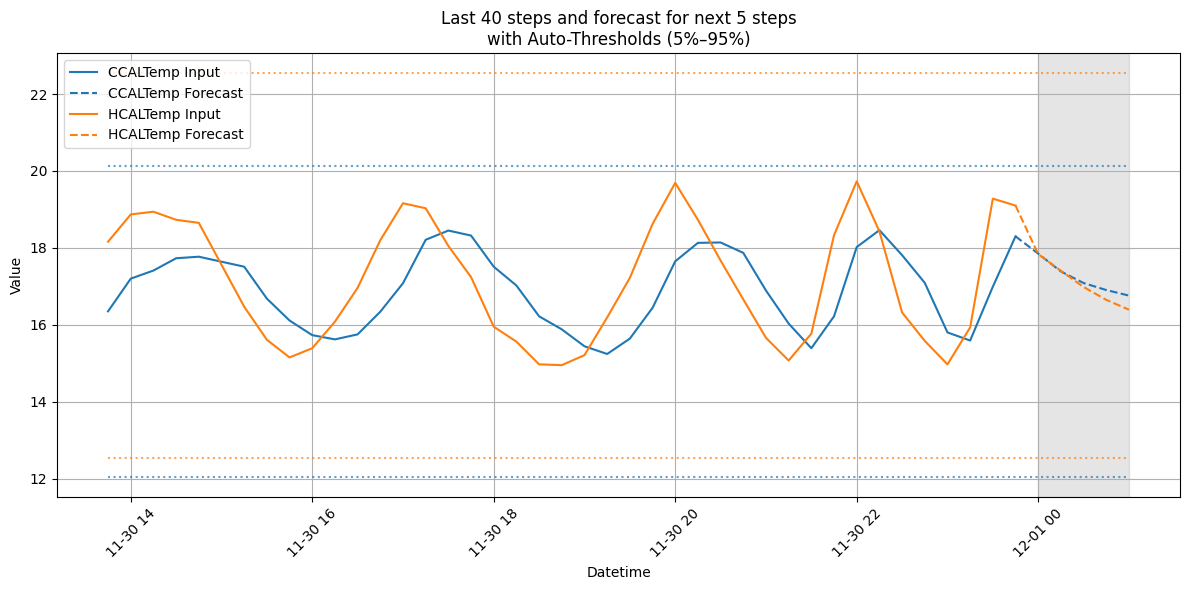

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================= PARAMETERS =================
seq_len = 40
forecast_steps = 5

# ================= PREPARE INPUT =================
df.index = pd.to_datetime(df.index)
input_seq = df.iloc[-seq_len:].values

# Scale input
input_seq_scaled = np.zeros_like(input_seq)
for i, col in enumerate(df.columns):
    input_seq_scaled[:, i] = scalers[col].transform(input_seq[:, i].reshape(-1, 1)).flatten()
input_seq_scaled = input_seq_scaled.reshape(1, seq_len, df.shape[1])

# ================= RECURSIVE FORECAST =================
current_input = input_seq_scaled.copy()
predicted_scaled = []

for _ in range(forecast_steps):
    next_step_scaled = model.predict(current_input, verbose=0)
    predicted_scaled.append(next_step_scaled.flatten())
    current_input = np.append(current_input[:, 1:, :], next_step_scaled.reshape(1, 1, df.shape[1]), axis=1)

predicted_scaled = np.array(predicted_scaled)

# Inverse transform
predicted_actual = np.zeros_like(predicted_scaled)
for i, col in enumerate(df.columns):
    predicted_actual[:, i] = scalers[col].inverse_transform(predicted_scaled[:, i].reshape(-1, 1)).flatten()

# ================= TIMESTAMPS =================
if df.index.inferred_freq is not None:
    freq = df.index.inferred_freq
else:
    freq = df.index[-1] - df.index[-2]

timestamps_input = df.index[-seq_len:]
timestamps_forecast = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq=freq)[1:]

# ================= AUTO-THRESHOLDS =================
auto_thresholds = {}
for col in df.columns:
    q_low = df[col].quantile(0.05)   # 5th percentile
    q_high = df[col].quantile(0.95)  # 95th percentile
    auto_thresholds[col] = (q_low, q_high)

print("📌 Auto thresholds (5th–95th percentiles):")
for col, (low, high) in auto_thresholds.items():
    print(f"{col}: lower={low:.2f}, upper={high:.2f}")

# ================= PLOT CONTINUOUS LINE WITH DASHED FORECAST + THRESHOLDS =================
plt.figure(figsize=(12,6))
for i, col in enumerate(df.columns):
    # Plot input as solid line
    plt.plot(timestamps_input, input_seq[:, i], color=f"C{i}", label=f'{col} Input')

    # Combine last input point + forecast to make continuous dashed line
    dashed_timestamps = np.array([timestamps_input[-1]] + list(timestamps_forecast))
    dashed_values = np.concatenate([[input_seq[-1, i]], predicted_actual[:, i]])

    # Plot forecast as dashed line
    plt.plot(dashed_timestamps, dashed_values, '--', color=f"C{i}", label=f'{col} Forecast')

    # Plot thresholds as horizontal lines
    low, high = auto_thresholds[col]
    plt.hlines(low, timestamps_input[0], timestamps_forecast[-1], colors=f"C{i}", linestyles="dotted", alpha=0.7)
    plt.hlines(high, timestamps_input[0], timestamps_forecast[-1], colors=f"C{i}", linestyles="dotted", alpha=0.7)

# Highlight forecast region
plt.axvspan(timestamps_forecast[0], timestamps_forecast[-1], color='gray', alpha=0.2)

plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title(f'Last {seq_len} steps and forecast for next {forecast_steps} steps\nwith Auto-Thresholds (5%–95%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


📌 Auto thresholds (5th–95th percentiles):
CCALTemp: lower=12.05, upper=20.12
HCALTemp: lower=12.54, upper=22.54


d:\Downloads\AHU\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Downloads\AHU\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


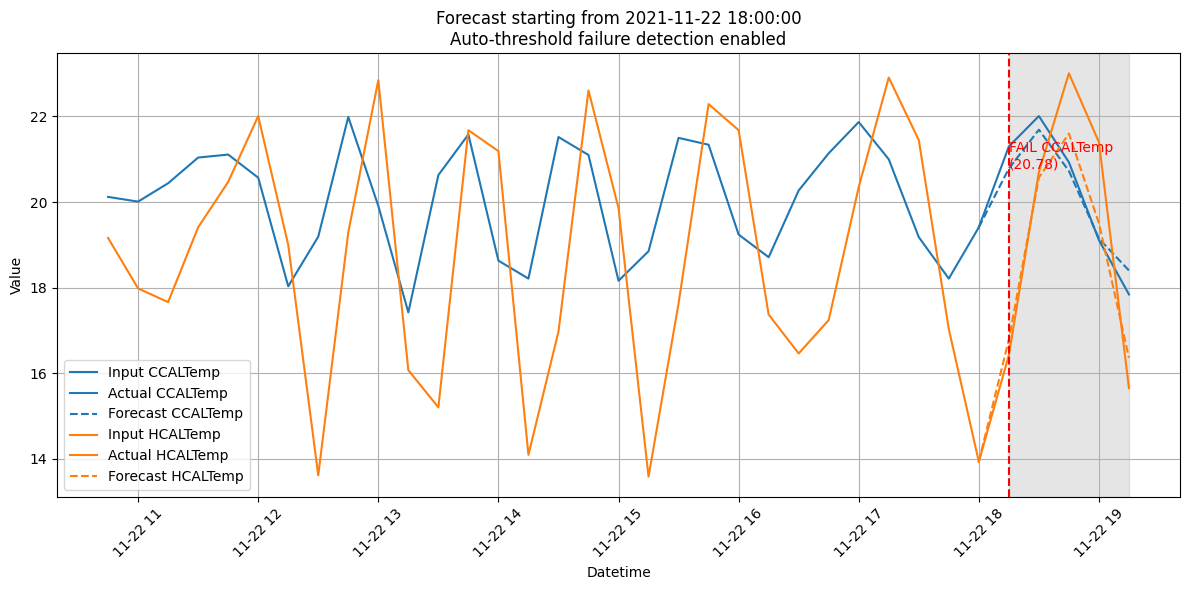


⚠️ Failure detected:
CCALTemp will likely fail at 2021-11-22 18:15:00 (forecasted 20.78)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= PARAMETERS =================
seq_len = 30        # input sequence length
forecast_steps = 5  # forecast next 5 steps
target_datetime = pd.to_datetime("2021-11-22 18:00:00")  # chosen datetime

# ================= AUTO THRESHOLDS =================
# Compute thresholds dynamically from historical data
auto_thresholds = {}
for col in df.columns:
    q_low = df[col].quantile(0.05)   # 5th percentile
    q_high = df[col].quantile(0.95)  # 95th percentile
    auto_thresholds[col] = (q_low, q_high)

print("📌 Auto thresholds (5th–95th percentiles):")
for col, (low, high) in auto_thresholds.items():
    print(f"{col}: lower={low:.2f}, upper={high:.2f}")

# ================= GET INPUT SEQUENCE =================
df.index = pd.to_datetime(df.index)
end_idx = df.index.get_loc(target_datetime)

input_seq = df.iloc[end_idx-seq_len+1:end_idx+1].values
input_seq_scaled = np.zeros_like(input_seq)
for i, col in enumerate(df.columns):
    input_seq_scaled[:, i] = scalers[col].transform(input_seq[:, i].reshape(-1,1)).flatten()
input_seq_scaled = input_seq_scaled.reshape(1, seq_len, df.shape[1])

# ================= FORECAST =================
current_input = input_seq_scaled.copy()
forecast_scaled = []
for _ in range(forecast_steps):
    next_step_scaled = model.predict(current_input, verbose=0)
    forecast_scaled.append(next_step_scaled.flatten())
    current_input = np.append(current_input[:,1:,:], next_step_scaled.reshape(1,1,df.shape[1]), axis=1)

forecast_scaled = np.array(forecast_scaled)

# ================= INVERSE SCALE =================
forecast_actual = np.zeros_like(forecast_scaled)
for i, col in enumerate(df.columns):
    forecast_actual[:, i] = scalers[col].inverse_transform(forecast_scaled[:, i].reshape(-1,1)).flatten()

# ================= GET ACTUAL FUTURE =================
actual_next = df.iloc[end_idx+1:end_idx+1+forecast_steps].values
timestamps_input = df.index[end_idx-seq_len+1:end_idx+1]
timestamps_forecast = df.index[end_idx+1:end_idx+1+forecast_steps]

# ================= FAILURE DETECTION =================
failure_times = []
for i, col in enumerate(df.columns):
    low, high = auto_thresholds[col]
    # Find violations
    fails = np.where((forecast_actual[:, i] < low) | (forecast_actual[:, i] > high))[0]
    if len(fails) > 0:
        fail_idx = fails[0]  # first failure
        failure_times.append((col, timestamps_forecast[fail_idx], forecast_actual[fail_idx, i]))


# ================= PLOT INPUT + FORECAST + ACTUAL =================
plt.figure(figsize=(12,6))
for i, col in enumerate(df.columns):
    # Input sequence
    plt.plot(timestamps_input, input_seq[:, i], label=f'Input {col}', color=f"C{i}")

    # Actual future (start from last input point for continuity)
    plt.plot(
        [timestamps_input[-1]] + list(timestamps_forecast),
        [input_seq[-1, i]] + list(actual_next[:, i]),
        '-', label=f'Actual {col}', color=f"C{i}"
    )

    # Forecasted future (start from last input point for continuity)
    plt.plot(
        [timestamps_input[-1]] + list(timestamps_forecast),
        [input_seq[-1, i]] + list(forecast_actual[:, i]),
        '--', label=f'Forecast {col}', color=f"C{i}"
    )

# Highlight forecast region
plt.axvspan(timestamps_forecast[0], timestamps_forecast[-1], color='gray', alpha=0.2)

# Mark failure points
for col, t, val in failure_times:
    plt.axvline(x=t, color='red', linestyle='--')
    plt.text(t, val, f'FAIL {col}\n({val:.2f})', color='red')

plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title(f'Forecast starting from {target_datetime}\nAuto-threshold failure detection enabled')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ================= REPORT FAILURES =================
if failure_times:
    print("\n⚠️ Failure detected:")
    for col, t, val in failure_times:
        print(f"{col} will likely fail at {t} (forecasted {val:.2f})")
else:
    print("\n✅ No failure detected within forecast horizon.")


d:\Downloads\AHU\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Downloads\AHU\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


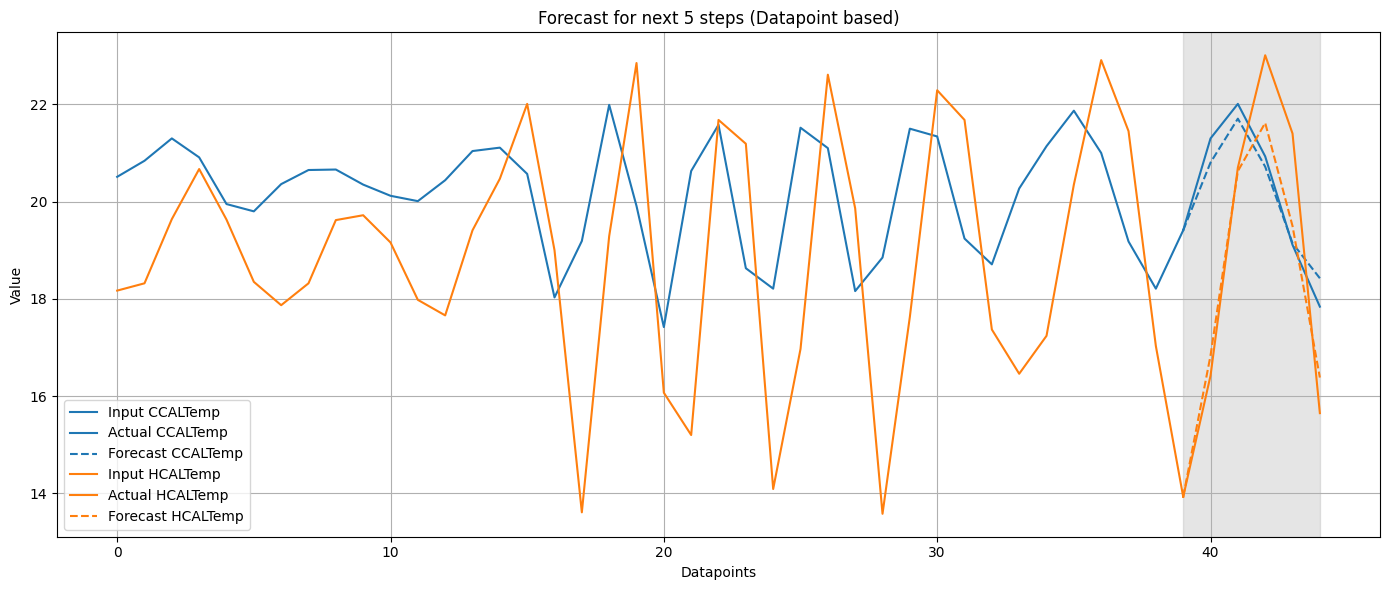

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ================= PARAMETERS =================
seq_len = 40
forecast_steps = 5
target_datetime = pd.to_datetime("2021-11-22 18:00:00")
columns_to_forecast = df.columns.tolist()

# ================= GET INPUT SEQUENCE =================
df.index = pd.to_datetime(df.index)
end_idx = df.index.get_loc(target_datetime)

input_seq = df.iloc[end_idx - seq_len + 1 : end_idx + 1].values
input_seq_scaled = np.zeros_like(input_seq, dtype=float)

# Scale input sequence
for i, col in enumerate(columns_to_forecast):
    input_seq_scaled[:, i] = scalers[col].transform(input_seq[:, i].reshape(-1, 1)).flatten()

input_seq_scaled = input_seq_scaled.reshape(1, seq_len, len(columns_to_forecast))

# ================= RECURSIVE FORECAST =================
current_input = input_seq_scaled.copy()
forecast_scaled = []

for _ in range(forecast_steps):
    next_step_scaled = model.predict(current_input, verbose=0)
    forecast_scaled.append(next_step_scaled.flatten())
    current_input = np.append(
        current_input[:, 1:, :],
        next_step_scaled.reshape(1, 1, len(columns_to_forecast)),
        axis=1
    )

forecast_scaled = np.array(forecast_scaled)

# ================= INVERSE SCALE =================
forecast_actual = np.zeros_like(forecast_scaled, dtype=float)
for i, col in enumerate(columns_to_forecast):
    forecast_actual[:, i] = scalers[col].inverse_transform(
        forecast_scaled[:, i].reshape(-1, 1)
    ).flatten()

# ================= ACTUAL FUTURE =================
actual_next = df.iloc[end_idx + 1 : end_idx + 1 + forecast_steps].values
timestamps_input = df.index[end_idx - seq_len + 1 : end_idx + 1]
timestamps_forecast = df.index[end_idx + 1 : end_idx + 1 + forecast_steps]

# ================= CALCULATE METRICS =================
metrics_dict = {}
for i, col in enumerate(columns_to_forecast):
    mae = mean_absolute_error(actual_next[:, i], forecast_actual[:, i])
    rmse = np.sqrt(mean_squared_error(actual_next[:, i], forecast_actual[:, i]))
    r2 = r2_score(actual_next[:, i], forecast_actual[:, i])
    metrics_dict[col] = (mae, rmse, r2)

# ================= PLOT =================
# ================= PLOT INPUT + FORECAST + ACTUAL (Datapoints) =================
plt.figure(figsize=(14, 6))

for i, col in enumerate(df.columns):
    # Define datapoint indices
    x_input = np.arange(len(input_seq))              # input points (0 to 39 if seq_len=40)
    x_forecast = np.arange(len(input_seq)-1, len(input_seq)-1+forecast_steps+1)

    # Input sequence
    plt.plot(x_input, input_seq[:, i], label=f'Input {col}', color=f"C{i}")

    # Actual future (include last input point for smooth overlap)
    plt.plot(
        x_forecast,
        [input_seq[-1, i]] + list(actual_next[:, i]),
        '-', label=f'Actual {col}', color=f"C{i}"
    )

    # Forecasted future (start from last input point for continuity)
    plt.plot(
        x_forecast,
        [input_seq[-1, i]] + list(forecast_actual[:, i]),
        '--', label=f'Forecast {col}', color=f"C{i}"
    )

# Highlight forecast region
plt.axvspan(len(input_seq)-1, len(input_seq)-1+forecast_steps, color='gray', alpha=0.2)

plt.xlabel('Datapoints')
plt.ylabel('Value')
plt.title(f'Forecast for next {forecast_steps} steps (Datapoint based)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


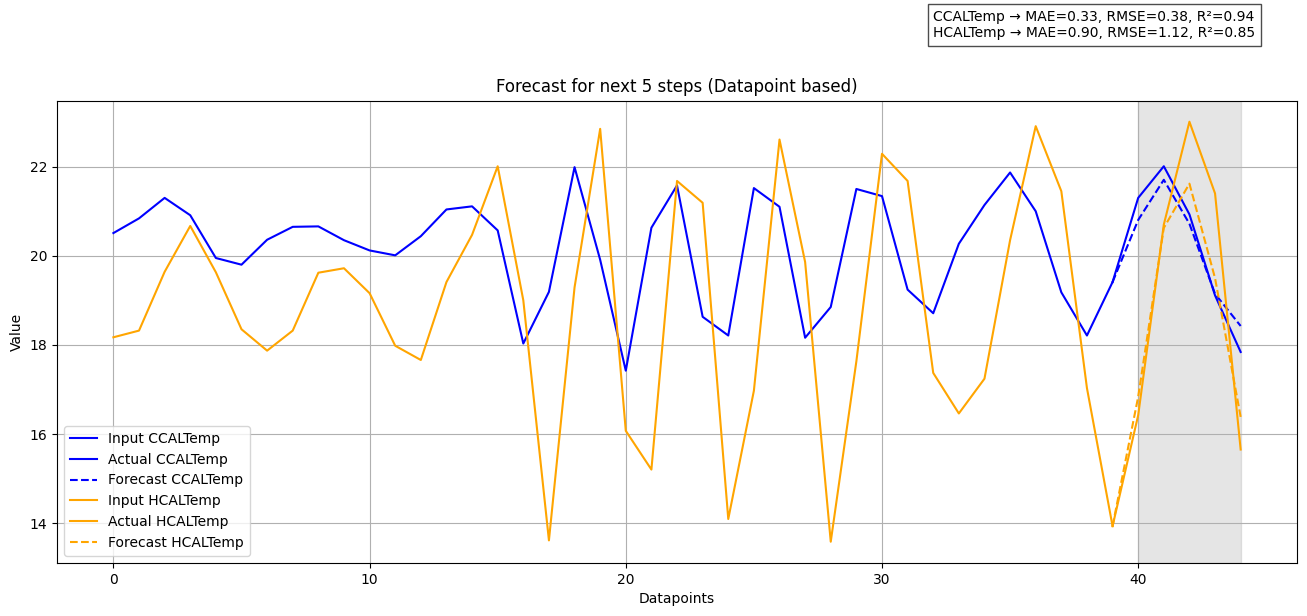

Forecast Performance:
CCALTemp → MAE=0.33, RMSE=0.38, R²=0.94
HCALTemp → MAE=0.90, RMSE=1.12, R²=0.85


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf

# ================= LOAD DATA =================
df = pd.read_csv("Data_Article_Dataset.csv")
df = df[['Datetime', 'CCALTemp', 'HCALTemp']].dropna()
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

# ================= SCALERS =================
scalers = {}
scaled_values = pd.DataFrame(index=df.index)
for col in df.columns:
    scalers[col] = MinMaxScaler()
    scaled_values[col] = scalers[col].fit_transform(df[[col]])

# ================= PARAMETERS =================
seq_len = 40        # input sequence length
forecast_steps = 5 # forecast steps
target_datetime = pd.to_datetime("2021-11-22 18:00:00")

# ================= GET INPUT =================
end_idx = df.index.get_loc(target_datetime)
input_seq = scaled_values.iloc[end_idx-seq_len+1:end_idx+1].values.reshape(1, seq_len, df.shape[1])

# ================= LOAD MODEL =================
model = tf.keras.models.load_model("D:\Downloads\AHU\my_trained_model.keras")  # <-- replace with your saved model

# ================= FORECAST (Recursive) =================
current_input = input_seq.copy()
forecast_scaled = []
for _ in range(forecast_steps):
    next_step_scaled = model.predict(current_input, verbose=0)
    forecast_scaled.append(next_step_scaled.flatten())
    current_input = np.append(current_input[:, 1:, :],
                              next_step_scaled.reshape(1, 1, df.shape[1]),
                              axis=1)

forecast_scaled = np.array(forecast_scaled)

# ================= INVERSE SCALE =================
forecast_actual = np.zeros_like(forecast_scaled)
for i, col in enumerate(df.columns):
    forecast_actual[:, i] = scalers[col].inverse_transform(
        forecast_scaled[:, i].reshape(-1, 1)
    ).flatten()

# ================= ACTUAL NEXT STEPS =================
actual_next = df.iloc[end_idx+1:end_idx+1+forecast_steps].values

# ================= SEPARATE FOR PLOT =================
input_ccal = df['CCALTemp'].iloc[end_idx-seq_len+1:end_idx+1].values
actual_ccal = actual_next[:, 0]
forecast_ccal = forecast_actual[:, 0]

input_hcal = df['HCALTemp'].iloc[end_idx-seq_len+1:end_idx+1].values
actual_hcal = actual_next[:, 1]
forecast_hcal = forecast_actual[:, 1]

# ================= METRICS =================
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

mae_ccal, rmse_ccal, r2_ccal = calculate_metrics(actual_ccal, forecast_ccal)
mae_hcal, rmse_hcal, r2_hcal = calculate_metrics(actual_hcal, forecast_hcal)

# ================= PLOT =================
plt.figure(figsize=(16, 6))

# CCALTemp
plt.plot(range(len(input_ccal)), input_ccal, label="Input CCALTemp", color="blue")
plt.plot(range(len(input_ccal)-1, len(input_ccal)+len(actual_ccal)),
         [input_ccal[-1]] + list(actual_ccal), '-', label="Actual CCALTemp", color="blue")
plt.plot(range(len(input_ccal)-1, len(input_ccal)+len(forecast_ccal)),
         [input_ccal[-1]] + list(forecast_ccal), '--', label="Forecast CCALTemp", color="blue")

# HCALTemp
plt.plot(range(len(input_hcal)), input_hcal, label="Input HCALTemp", color="orange")
plt.plot(range(len(input_hcal)-1, len(input_hcal)+len(actual_hcal)),
         [input_hcal[-1]] + list(actual_hcal), '-', label="Actual HCALTemp", color="orange")
plt.plot(range(len(input_hcal)-1, len(input_hcal)+len(forecast_hcal)),
         [input_hcal[-1]] + list(forecast_hcal), '--', label="Forecast HCALTemp", color="orange")

# Highlight forecast region
plt.axvspan(len(input_ccal), len(input_ccal)+len(forecast_ccal)-1, color='gray', alpha=0.2)

plt.xlabel("Datapoints")
plt.ylabel("Value")
plt.title(f"Forecast for next {forecast_steps} steps (Datapoint based)")

# Add metrics box
metrics_text = (
    f"CCALTemp → MAE={mae_ccal:.2f}, RMSE={rmse_ccal:.2f}, R²={r2_ccal:.2f}\n"
    f"HCALTemp → MAE={mae_hcal:.2f}, RMSE={rmse_hcal:.2f}, R²={r2_hcal:.2f}"
)
plt.text(len(input_ccal)-8, max(max(input_ccal), max(input_hcal))+2,
         metrics_text, fontsize=10, bbox=dict(facecolor="white", alpha=0.7))

plt.legend()
plt.grid(True)
plt.show()
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# CCAL
mae_ccal, rmse_ccal, r2_ccal = calculate_metrics(actual_ccal, forecast_ccal)

# HCAL
mae_hcal, rmse_hcal, r2_hcal = calculate_metrics(actual_hcal, forecast_hcal)

# ================= PRINT METRICS =================
print("Forecast Performance:")
print(f"CCALTemp → MAE={mae_ccal:.2f}, RMSE={rmse_ccal:.2f}, R²={r2_ccal:.2f}")
print(f"HCALTemp → MAE={mae_hcal:.2f}, RMSE={rmse_hcal:.2f}, R²={r2_hcal:.2f}")


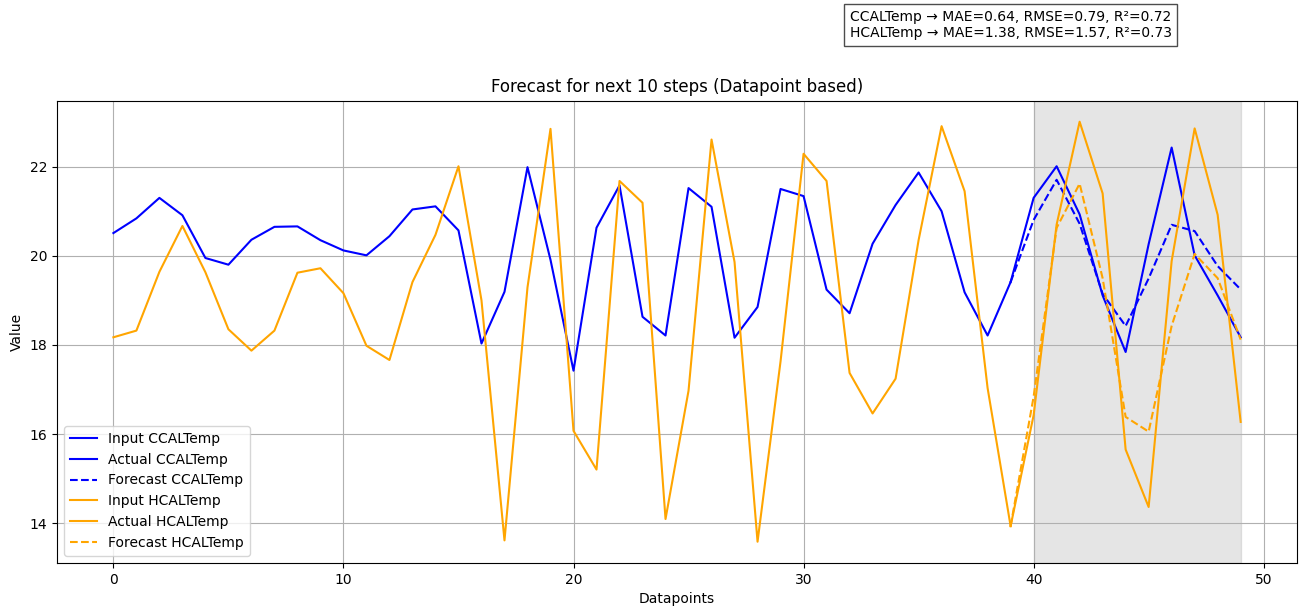

Forecast Performance:
CCALTemp → MAE=0.64, RMSE=0.79, R²=0.72
HCALTemp → MAE=1.38, RMSE=1.57, R²=0.73


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf

# ================= LOAD DATA =================
df = pd.read_csv("Data_Article_Dataset.csv")
df = df[['Datetime', 'CCALTemp', 'HCALTemp']].dropna()
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

# ================= SCALERS =================
scalers = {}
scaled_values = pd.DataFrame(index=df.index)
for col in df.columns:
    scalers[col] = MinMaxScaler()
    scaled_values[col] = scalers[col].fit_transform(df[[col]])

# ================= PARAMETERS =================
seq_len = 40        # input sequence length
forecast_steps = 10 # forecast steps
target_datetime = pd.to_datetime("2021-11-22 18:00:00")

# ================= GET INPUT =================
end_idx = df.index.get_loc(target_datetime)
input_seq = scaled_values.iloc[end_idx-seq_len+1:end_idx+1].values.reshape(1, seq_len, df.shape[1])

# ================= LOAD MODEL =================
model = tf.keras.models.load_model("my_trained_model.keras")  # <-- replace with your saved model

# ================= FORECAST (Recursive) =================
current_input = input_seq.copy()
forecast_scaled = []
for _ in range(forecast_steps):
    next_step_scaled = model.predict(current_input, verbose=0)
    forecast_scaled.append(next_step_scaled.flatten())
    current_input = np.append(current_input[:, 1:, :],
                              next_step_scaled.reshape(1, 1, df.shape[1]),
                              axis=1)

forecast_scaled = np.array(forecast_scaled)

# ================= INVERSE SCALE =================
forecast_actual = np.zeros_like(forecast_scaled)
for i, col in enumerate(df.columns):
    forecast_actual[:, i] = scalers[col].inverse_transform(
        forecast_scaled[:, i].reshape(-1, 1)
    ).flatten()

# ================= ACTUAL NEXT STEPS =================
actual_next = df.iloc[end_idx+1:end_idx+1+forecast_steps].values

# ================= SEPARATE FOR PLOT =================
input_ccal = df['CCALTemp'].iloc[end_idx-seq_len+1:end_idx+1].values
actual_ccal = actual_next[:, 0]
forecast_ccal = forecast_actual[:, 0]

input_hcal = df['HCALTemp'].iloc[end_idx-seq_len+1:end_idx+1].values
actual_hcal = actual_next[:, 1]
forecast_hcal = forecast_actual[:, 1]

# ================= METRICS =================
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

mae_ccal, rmse_ccal, r2_ccal = calculate_metrics(actual_ccal, forecast_ccal)
mae_hcal, rmse_hcal, r2_hcal = calculate_metrics(actual_hcal, forecast_hcal)

# ================= PLOT =================
plt.figure(figsize=(16, 6))

# CCALTemp
plt.plot(range(len(input_ccal)), input_ccal, label="Input CCALTemp", color="blue")
plt.plot(range(len(input_ccal)-1, len(input_ccal)+len(actual_ccal)),
         [input_ccal[-1]] + list(actual_ccal), '-', label="Actual CCALTemp", color="blue")
plt.plot(range(len(input_ccal)-1, len(input_ccal)+len(forecast_ccal)),
         [input_ccal[-1]] + list(forecast_ccal), '--', label="Forecast CCALTemp", color="blue")

# HCALTemp
plt.plot(range(len(input_hcal)), input_hcal, label="Input HCALTemp", color="orange")
plt.plot(range(len(input_hcal)-1, len(input_hcal)+len(actual_hcal)),
         [input_hcal[-1]] + list(actual_hcal), '-', label="Actual HCALTemp", color="orange")
plt.plot(range(len(input_hcal)-1, len(input_hcal)+len(forecast_hcal)),
         [input_hcal[-1]] + list(forecast_hcal), '--', label="Forecast HCALTemp", color="orange")

# Highlight forecast region
plt.axvspan(len(input_ccal), len(input_ccal)+len(forecast_ccal)-1, color='gray', alpha=0.2)

plt.xlabel("Datapoints")
plt.ylabel("Value")
plt.title(f"Forecast for next {forecast_steps} steps (Datapoint based)")

# Add metrics box
metrics_text = (
    f"CCALTemp → MAE={mae_ccal:.2f}, RMSE={rmse_ccal:.2f}, R²={r2_ccal:.2f}\n"
    f"HCALTemp → MAE={mae_hcal:.2f}, RMSE={rmse_hcal:.2f}, R²={r2_hcal:.2f}"
)
plt.text(len(input_ccal)-8, max(max(input_ccal), max(input_hcal))+2,
         metrics_text, fontsize=10, bbox=dict(facecolor="white", alpha=0.7))

plt.legend()
plt.grid(True)
plt.show()
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# CCAL
mae_ccal, rmse_ccal, r2_ccal = calculate_metrics(actual_ccal, forecast_ccal)

# HCAL
mae_hcal, rmse_hcal, r2_hcal = calculate_metrics(actual_hcal, forecast_hcal)

# ================= PRINT METRICS =================
print("Forecast Performance:")
print(f"CCALTemp → MAE={mae_ccal:.2f}, RMSE={rmse_ccal:.2f}, R²={r2_ccal:.2f}")
print(f"HCALTemp → MAE={mae_hcal:.2f}, RMSE={rmse_hcal:.2f}, R²={r2_hcal:.2f}")
